## PPC

In [1]:
import sys
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import torch

import scvi
from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, Posterior, UnsupervisedTrainer

import anndata
import scanpy as sc
import umap
import sparse

sns.set(context="notebook", font_scale=1.3, style="ticks")
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline
overwrite=False

sys.path.append("../utils/")
from totalppc import TotalPosteriorPredictiveCheck as totalPPC
from scvi import set_seed

# colors = ["#9b59b6", "#3498db", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]
# colors_3 = ["#9b59b6", "#95a5a6", "#34495e", "#e74c3c", "#2ecc71"]

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
colors_3 = ["#3B7EA1", "#D9661F", "#859438", "#EE1F60", "#00A598"]

set_seed(0)

In [2]:
anndataset_pbmc = anndata.read(save_path + "pbmc_10k_protein_v3.h5ad")
anndataset_malt = anndata.read(save_path + "malt_10k_protein_v3.h5ad")
anndataset_sln = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset_sln = anndataset_sln[anndataset_sln.obs["batch_indices"] == 0]

In [3]:
dataset_pbmc = AnnDatasetFromAnnData(ad=anndataset_pbmc)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_pbmc.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_pbmc.uns["protein_names"],
)
dataset_pbmc.initialize_cell_measurement(protein_data)

dataset_malt = AnnDatasetFromAnnData(ad=anndataset_malt)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_malt.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_malt.uns["protein_names"],
)
dataset_malt.initialize_cell_measurement(protein_data)

# Removes HTOs
dataset_sln = AnnDatasetFromAnnData(ad=anndataset_sln)
protein_data = CellMeasurement(
    name="protein_expression",
    data=anndataset_sln.obsm["protein_expression"][:, :-2].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset_sln.uns["protein_names"][:-2],
)
dataset_sln.initialize_cell_measurement(protein_data)

datasets = [dataset_pbmc, dataset_malt, dataset_sln]

[2020-09-02 08:58:05,057] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-02 08:58:05,059] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-02 08:58:05,243] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 08:58:05,430] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-09-02 08:58:05,836] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-02 08:58:05,837] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-02 08:58:06,021] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 08:58:06,205] INFO - scvi.dataset.dataset | Downsampled from 6838 to 6838 cells
[2020-09-02 08:58:06,652] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-02 08:58:06,653] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-02 08:58:06,893] INFO - scvi.dataset.dataset | Computing the library size for the new data
[20

In [4]:
for d in datasets:
    d.update_genes(d.var["highly_variable"])

[2020-09-02 08:58:07,146] INFO - scvi.dataset.dataset | Downsampling from 16727 to 4000 genes
[2020-09-02 08:58:07,268] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 08:58:07,360] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-09-02 08:58:07,453] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 08:58:07,500] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-09-02 08:58:07,501] INFO - scvi.dataset.dataset | Downsampling from 16659 to 4000 genes
[2020-09-02 08:58:07,622] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 08:58:07,701] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-09-02 08:58:07,779] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-02 08:58:07,825] INFO - scvi.dataset.dataset | Downsampled from 6838 to 6838 cells
[2020-09-02 08:58:07,826] INFO - scvi.dataset.datase

In [5]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [6]:
vae_pbmc = TOTALVI(dataset_pbmc.nb_genes, len(dataset_pbmc.protein_names))
vae_malt = TOTALVI(dataset_malt.nb_genes, len(dataset_malt.protein_names))
vae_sln = TOTALVI(dataset_sln.nb_genes, len(dataset_sln.protein_names))


trainer_pbmc = TotalTrainer(
    vae_pbmc,
    dataset_pbmc,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256},
    early_stopping_kwargs=early_stopping_kwargs,
)

trainer_malt = TotalTrainer(
    vae_malt,
    dataset_malt,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256},
    early_stopping_kwargs=early_stopping_kwargs,
)

trainer_sln = TotalTrainer(
    vae_sln,
    dataset_sln,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size":256},
    early_stopping_kwargs=early_stopping_kwargs,
)

In [7]:
scvi_pbmc = VAE(dataset_pbmc.nb_genes, n_latent=20, reconstruction_loss="nb")
scvi_malt = VAE(dataset_malt.nb_genes, n_latent=20, reconstruction_loss="nb")
scvi_sln = VAE(dataset_sln.nb_genes, n_latent=20, reconstruction_loss="nb")

scvi_trainer_pbmc = UnsupervisedTrainer(
    scvi_pbmc,
    dataset_pbmc,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=10,
)

scvi_trainer_malt = UnsupervisedTrainer(
    scvi_malt,
    dataset_malt,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=10,
)

scvi_trainer_sln = UnsupervisedTrainer(
    scvi_sln,
    dataset_sln,
    train_size=0.80,
    test_size=0.05,
    use_cuda=use_cuda,
    frequency=10,
)

In [8]:
if overwrite is True:
    trainer_pbmc.train(lr=lr, n_epochs=500)
    torch.save(trainer_pbmc.model.state_dict(), "saved_models/pbmc10k_ppc.pt")
    trainer_malt.train(lr=lr, n_epochs=500)
    torch.save(trainer_malt.model.state_dict(), "saved_models/malt_ppc.pt")
    trainer_sln.train(lr=lr, n_epochs=500)
    torch.save(trainer_sln.model.state_dict(), "saved_models/sln_ppc.pt")
    scvi_trainer_pbmc.train(lr=2e-3, n_epochs=500)
    torch.save(scvi_trainer_pbmc.model.state_dict(), "saved_models/scvi_pbmc10k_ppc.pt")
    scvi_trainer_malt.train(lr=2e-3, n_epochs=500)
    torch.save(scvi_trainer_malt.model.state_dict(), "saved_models/scvi_malt_ppc.pt")
    scvi_trainer_sln.train(lr=2e-3, n_epochs=500)
    torch.save(scvi_trainer_sln.model.state_dict(), "saved_models/scvi_sln_ppc.pt")
else:
    # totalVI
    try:
        vae_pbmc.load_state_dict(torch.load("saved_models/pbmc10k_ppc.pt"))
        vae_pbmc.eval()
    except FileNotFoundError:
        trainer_pbmc.train(lr=lr, n_epochs=500)
        torch.save(trainer_pbmc.model.state_dict(), "saved_models/pbmc10k_ppc.pt")
    try:
        vae_malt.load_state_dict(torch.load("saved_models/malt_ppc.pt"))
        vae_malt.eval()
    except FileNotFoundError:
        trainer_malt.train(lr=lr, n_epochs=500)
        torch.save(trainer_malt.model.state_dict(), "saved_models/malt_ppc.pt")
    try:
        vae_sln.load_state_dict(torch.load("saved_models/sln_ppc.pt"))
        vae_sln.eval()
    except FileNotFoundError:
        trainer_sln.train(lr=lr, n_epochs=500)
        torch.save(trainer_sln.model.state_dict(), "saved_models/sln_ppc.pt")
    # scVI
    try:
        scvi_pbmc.load_state_dict(torch.load("saved_models/scvi_pbmc10k_ppc.pt"))
        scvi_pbmc.eval()
    except FileNotFoundError:
        scvi_trainer_pbmc.train(lr=lr, n_epochs=500)
        torch.save(scvi_trainer_pbmc.model.state_dict(), "saved_models/scvi_pbmc10k_ppc.pt")
    try:
        scvi_malt.load_state_dict(torch.load("saved_models/scvi_malt_ppc.pt"))
        scvi_malt.eval()
    except FileNotFoundError:
        scvi_trainer_malt.train(lr=lr, n_epochs=500)
        torch.save(scvi_trainer_malt.model.state_dict(), "saved_models/scvi_malt_ppc.pt")
    try:
        scvi_sln.load_state_dict(torch.load("saved_models/scvi_sln_ppc.pt"))
        scvi_sln.eval()
    except FileNotFoundError:
        scvi_trainer_sln.train(lr=2e-3, n_epochs=500)
        torch.save(scvi_trainer_sln.model.state_dict(), "saved_models/scvi_sln_ppc.pt")

In [9]:
post_pbmc = trainer_pbmc.train_set

full_data_pbmc = np.concatenate(
    [dataset_pbmc.X, dataset_pbmc.protein_expression], axis=1
)

post_malt = trainer_malt.train_set

full_data_malt = np.concatenate(
    [dataset_malt.X, dataset_malt.protein_expression], axis=1
)

post_sln = trainer_sln.train_set

full_data_sln = np.concatenate(
    [dataset_sln.X, dataset_sln.protein_expression], axis=1
)

scvi_post_pbmc = scvi_trainer_pbmc.train_set
scvi_post_malt = scvi_trainer_malt.train_set
scvi_post_sln = scvi_trainer_sln.train_set

In [10]:
ppc_held_pbmc = totalPPC(
    posteriors_dict={"totalVI": trainer_pbmc.validation_set},
    scvi_posts_dict={"scVI": scvi_trainer_pbmc.validation_set},
    n_samples=150,
)
ppc_full_pbmc = totalPPC(
    posteriors_dict={"totalVI": post_pbmc},
    scvi_posts_dict={"scVI": scvi_post_pbmc},
    n_samples=25,
)
ppc_held_malt = totalPPC(
    posteriors_dict={"totalVI": trainer_malt.validation_set},
    scvi_posts_dict={"scVI": scvi_trainer_malt.validation_set},
    n_samples=150,
)
ppc_full_malt = totalPPC(
    posteriors_dict={"totalVI": post_malt},
    scvi_posts_dict={"scVI": scvi_post_malt},
    n_samples=25,
)

ppc_held_sln = totalPPC(
    posteriors_dict={"totalVI": trainer_sln.validation_set},
    scvi_posts_dict={"scVI": scvi_trainer_sln.validation_set},
    n_samples=150,
)
ppc_full_sln = totalPPC(
    posteriors_dict={"totalVI": post_sln},
    scvi_posts_dict={"scVI": scvi_post_sln},
    n_samples=25,
)

In [11]:
ppc_helds = [ppc_held_pbmc, ppc_held_malt, ppc_held_sln]
full_datas = [full_data_pbmc, full_data_malt, full_data_sln]
trainers = [trainer_pbmc, trainer_malt, trainer_sln]

for p, fd, trainer in zip(ppc_helds, full_datas, trainers):
    train_indices = trainer.train_set.indices
    test_indices = trainer.validation_set.indices
    train_data = fd[trainer.train_set.indices]
    p.store_fa_samples(
        train_data,
        train_indices,
        test_indices,
        n_components=vae_pbmc.n_latent,
        normalization="log_rate",
        key="FA"
    )
    p.store_fa_samples(
        train_data,
        train_indices,
        test_indices,
        n_components=vae_pbmc.n_latent,
        normalization="log",
        key="FA",
    )
    p.store_schpf_samples(
        train_data,
        nfactors=vae_pbmc.n_latent
    )

/data/yosef2/users/adamgayoso/.pyenv/versions/scvi/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Clipping dp: was 2.291647831498267e-07 now 8.835147600620985e-07
[Iter.    0]  loss:197.236571  pct:100.000000000
[Iter.   10]  loss:7.768631  pct:-96.061262393
[Iter.   20]  loss:3.218945  pct:-58.564836475
[Iter.   30]  loss:2.857104  pct:-11.240971370
[Iter.   40]  loss:2.741476  pct:-4.047053833
[Iter.   50]  loss:2.672735  pct:-2.507453093
[Iter.   60]  loss:2.634019  pct:-1.448540521
[Iter.   70]  loss:2.613374  pct:-0.783782672
[Iter.   80]  loss:2.599283  pct:-0.539202530
[Iter.   90]  loss:2.589673  pct:-0.369716213
[Iter.  100]  loss:2.582129  pct:-0.291312139
[Iter.  110]  loss:2.575491  pct:-0.257047223
[Iter.  120]  loss:2.569833  pct:-0.219713629
[Iter.  130]  loss:2.564843  pct:-0.194156224
[Iter.  140]  loss:2.560407  pct:-0.172962797
[Iter.  150]  loss:2.556402  pct:-0.156429385
[Iter.  160]  loss:2.552658  pct:-0.146456862
[Iter.  170]  loss:2.549199  pct:-0.135498577
[Iter.  180]  loss:2.546026  pct:-0.124457479
[Iter.  190]  loss:2.543132  pct:-0.113669760
[Iter.  2

In [12]:
for p in ppc_helds:
    p.mean_absolute_error()

In [13]:
for p in ppc_helds:
    print(p.metrics["mean_ae"])

             totalVI      scVI  FA (Log Rate)    FA (Log)      scHPF
genes       0.195570  0.197502       0.242393    0.235229   0.216562
proteins  153.552155       NaN     162.163132  272.873444  14.971396
             totalVI      scVI  FA (Log Rate)    FA (Log)     scHPF
genes       0.210987  0.205664       0.257059    0.263494  0.216524
proteins  110.390388       NaN     129.792038  252.071564  9.903163
           totalVI      scVI  FA (Log Rate)   FA (Log)     scHPF
genes     0.251606  0.257085       0.292176   0.301577  0.261053
proteins  8.038754       NaN       9.876575  11.284501  5.889720


In [14]:
# ppc_helds[0].posterior_predictive_samples["scHPF"].todense()[:, -3]
# plt.hist(ppc_helds[0].raw_counts.todense()[:, -3])
# plt.hist(ppc_helds[0].posterior_predictive_samples["totalVI"].todense()[:, -3][1], bins=20)

In [15]:
for p in ppc_helds:
    p.calibration_error(confidence_intervals=[0.5, 99.5])

In [16]:
ppc_held_pbmc.metrics["calibration"]

,totalVI,scVI,FA (Log Rate),FA (Log),scHPF
genes,0.000038,0.000039,0.000442,0.000551,0.000014
proteins,0.000028,NaN,0.000191,0.000307,0.013129
total,0.000038,NaN,0.000440,0.000550,0.000011


In [17]:
def ppc_bar_plots(key="mean_ae"):
    cols = ["totalVI", "scVI", "FA (Log Rate)", "FA (Log)", "scHPF"]
    fig, ax = plt.subplots(2, 2, figsize=(9, 9))
    mae_genes = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    mae_genes.loc["PBMC", :] = ppc_held_pbmc.metrics[key].loc["genes"]
    mae_genes.loc["MALT", :] = ppc_held_malt.metrics[key].loc["genes"]
    mae_genes.loc["SLN111-D1", :] = ppc_held_sln.metrics[key].loc["genes"]
    mae_proteins = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    mae_proteins.loc["PBMC", :] = ppc_held_pbmc.metrics["mean_ae"].loc["proteins"]
    mae_proteins.loc["MALT", :] = ppc_held_malt.metrics["mean_ae"].loc["proteins"]
    mae_proteins.loc["SLN111-D1", :] = ppc_held_sln.metrics["mean_ae"].loc["proteins"]


    mae_genes[cols].plot(kind="bar", ax=ax.flat[0], legend=False, color=colors)
    mae_proteins = mae_proteins.drop(['scVI'], axis=1)
    print(mae_proteins)
    mae_proteins.plot(kind="bar", ax=ax.flat[1], legend=False, color=colors_3)

    cal_genes = pd.DataFrame(
        columns=ppc_held_pbmc.metrics[key].columns, index=["PBMC", "MALT", "SLN111-D1"]
    )
    cal_genes.loc["PBMC", :] = ppc_held_pbmc.metrics["calibration"].loc["genes"]
    cal_genes.loc["MALT", :] = ppc_held_malt.metrics["calibration"].loc["genes"]
    cal_genes.loc["SLN111-D1", :] = ppc_held_sln.metrics["calibration"].loc["genes"]
    cal_proteins = cal_genes.copy()
    cal_proteins.loc["PBMC", :] = ppc_held_pbmc.metrics["calibration"].loc["proteins"]
    cal_proteins.loc["MALT", :] = ppc_held_malt.metrics["calibration"].loc["proteins"]
    cal_proteins.loc["SLN111-D1", :] = ppc_held_sln.metrics["calibration"].loc["proteins"]

    print(cal_proteins)
    cal_proteins = cal_proteins.drop(['scVI'], axis=1)
    cal_genes[cols].plot(kind="bar", ax=ax.flat[2], legend=False, color=colors)
    cal_proteins.plot(kind="bar", ax=ax.flat[3], legend=False, color=colors_3)

    ax.flat[0].set_yscale('log')
    ax.flat[1].set_yscale('log')
    ax.flat[2].set_yscale('log')
    ax.flat[3].set_yscale('log')


    ax.flat[2].legend(fancybox=True, shadow=True, bbox_to_anchor=(0.1, -0.4))
    for a in ax.flat:
        a.tick_params(axis="x", rotation=0)
    ax.flat[0].set_title("Genes")
    ax.flat[1].set_title("Proteins")
    ax.flat[0].set_ylabel("Mean Absolute Error")
    ax.flat[2].set_ylabel("Calibration Error")
    sns.despine()
    

           totalVI FA (Log Rate) FA (Log)    scHPF
PBMC       153.552       162.163  272.873  14.9714
MALT        110.39       129.792  252.072  9.90316
SLN111-D1  8.03875       9.87658  11.2845  5.88972
               totalVI scVI FA (Log Rate)     FA (Log)       scHPF
PBMC       2.79447e-05  NaN   0.000191343  0.000306785   0.0131293
MALT       3.87022e-05  NaN   0.000196515  0.000326028  0.00619274
SLN111-D1   2.8095e-06  NaN   0.000542309  0.000300385  0.00610186


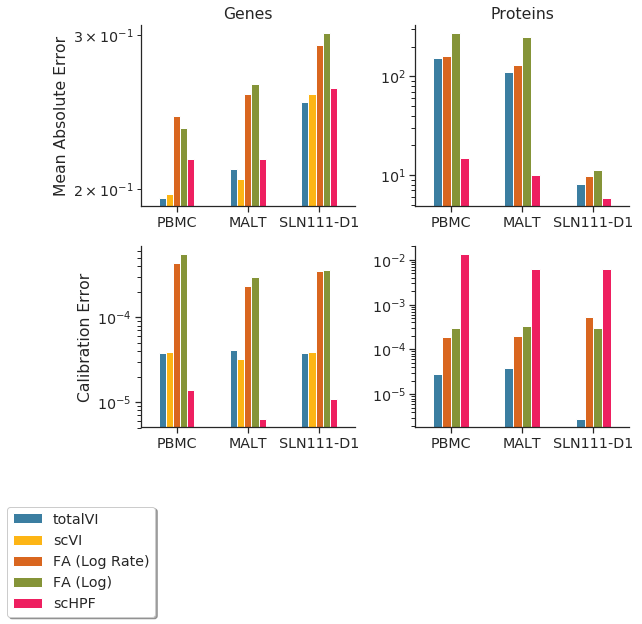

In [18]:
ppc_bar_plots(key="mean_ae")
plt.tight_layout()
plt.savefig("figures/mae_cal.pdf")

### Full data PPC

In [19]:
for p in ppc_helds:
    del p

In [20]:
# del p for p in ppc_helds
ppc_fulls = [ppc_full_pbmc, ppc_full_malt, ppc_full_sln]
for p, dataset in zip(ppc_fulls, datasets):
    p.store_fa_samples(
        p.raw_counts.todense(),
        np.arange(len(dataset)),
        np.arange(len(dataset)),
        n_components=vae_pbmc.n_latent,
        normalization="log",
        key="FA"
    )
    p.store_fa_samples(
        p.raw_counts.todense(),
        np.arange(len(dataset)),
        np.arange(len(dataset)),
        n_components=vae_pbmc.n_latent,
        normalization="log_rate",
        key="FA"
    )

In [21]:
for p, dataset in zip(ppc_fulls, datasets):
    p.store_schpf_samples(
        p.raw_counts.todense(),
        nfactors=vae_pbmc.n_latent,
    )

Clipping dp: was 2.291647831498267e-07 now 8.835147600620985e-07
[Iter.    0]  loss:201.069051  pct:100.000000000
[Iter.   10]  loss:6.249764  pct:-96.891732363
[Iter.   20]  loss:3.017280  pct:-51.721700411
[Iter.   30]  loss:2.724729  pct:-9.695844430
[Iter.   40]  loss:2.618915  pct:-3.883488883
[Iter.   50]  loss:2.564954  pct:-2.060430885
[Iter.   60]  loss:2.545017  pct:-0.777290497
[Iter.   70]  loss:2.533049  pct:-0.470221132
[Iter.   80]  loss:2.524271  pct:-0.346558284
[Iter.   90]  loss:2.517782  pct:-0.257070666
[Iter.  100]  loss:2.512350  pct:-0.215735636
[Iter.  110]  loss:2.507834  pct:-0.179753405
[Iter.  120]  loss:2.504137  pct:-0.147394722
[Iter.  130]  loss:2.500952  pct:-0.127191585
[Iter.  140]  loss:2.498324  pct:-0.105112871
[Iter.  150]  loss:2.495922  pct:-0.096122475
[Iter.  160]  loss:2.494017  pct:-0.076322519
[Iter.  170]  loss:2.492479  pct:-0.061691481
[Iter.  180]  loss:2.491152  pct:-0.053233920
[Iter.  190]  loss:2.490041  pct:-0.044573279
[Iter.  20

In [22]:
# Runtime warning is when samples have all zeros, we consider this as 0 cv
for p in ppc_fulls:
    p.coeff_of_variation(cell_wise=False)

../utils/totalppc.py:115: RuntimeWarning: invalid value encountered in true_divide
  np.std(samples, axis=axis) / np.mean(samples, axis=axis), axis=-1
../utils/totalppc.py:115: RuntimeWarning: Mean of empty slice
  np.std(samples, axis=axis) / np.mean(samples, axis=axis), axis=-1


In [23]:
cv_gene_mae_pbmc, cv_gene_mae_malt, cv_gene_mae_sln = {}, {}, {}
cv_pro_mae_pbmc, cv_pro_mae_malt, cv_pro_mae_sln = {}, {}, {}
cv_gene_maes = [cv_gene_mae_pbmc, cv_gene_mae_malt, cv_gene_mae_sln]
cv_pro_maes = [cv_pro_mae_pbmc, cv_pro_mae_malt, cv_pro_mae_sln]

for p, dataset, cv_gene_mae, cv_pro_mae in zip(ppc_fulls, datasets, cv_gene_maes, cv_pro_maes):
    for m, samples in p.posterior_predictive_samples.items():
        cv_gene_mae[m] = [np.mean(
            np.abs(
                p.metrics["cv_gene"][m].iloc[: dataset.nb_genes]
                - p.metrics["cv_gene"]["raw"].iloc[: dataset.nb_genes]
            )
        )]
        cv_pro_mae[m] = [np.mean(
            np.abs(
                p.metrics["cv_gene"][m].iloc[dataset.nb_genes:]
                - p.metrics["cv_gene"]["raw"].iloc[dataset.nb_genes:]
            )
        )]
    p.metrics["cv_gene_mae"] = pd.DataFrame.from_dict(cv_gene_mae)
    p.metrics["cv_pro_mae"] = pd.DataFrame.from_dict(cv_pro_mae)

In [24]:
(p.metrics["cv_gene_mae"].iloc[: dataset.nb_genes] == 0).sum(axis=0)

totalVI          0
scVI             0
FA (Log)         0
FA (Log Rate)    0
scHPF            0
dtype: int64

[[0.71 0.86 7.9  7.19 1.11]]
[['0.71' '0.86' '7.9' '7.19' '1.11' '--']]
[[ 1.39  1.91 12.1  10.56  2.62]]
[['1.39' '1.91' '12.1' '10.56' '2.62' '--']]
[[1.03 1.15 8.77 8.19 2.23]]
[['1.03' '1.15' '8.77' '8.19' '2.23' '--']]


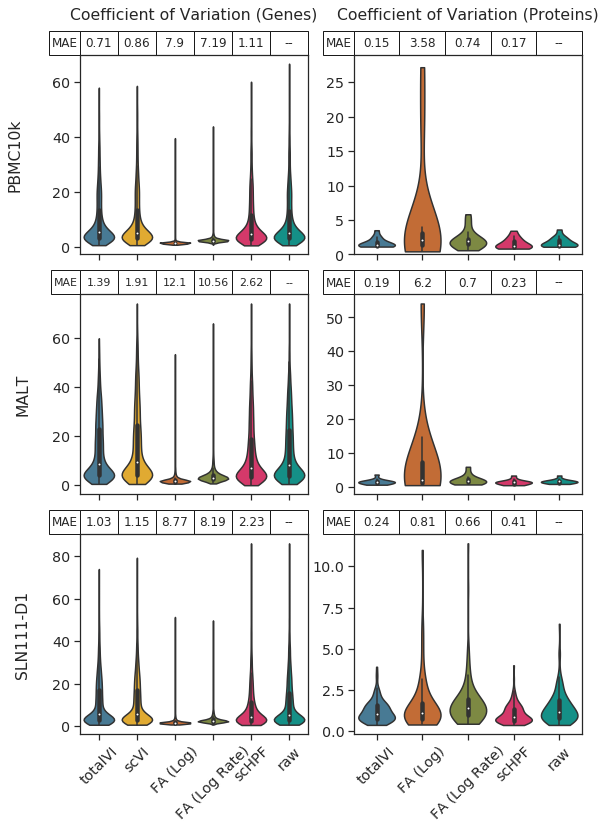

In [25]:
fig, ax = plt.subplots(3, 2, figsize=(9, 12.5), sharex=False)
inds = [0, 2, 4]
for i, p, dataset in zip(inds, ppc_fulls, datasets):
    gene_table = np.round(p.metrics["cv_gene_mae"].values, 2)
    print(gene_table)
    gene_table = np.concatenate([gene_table, np.array(["--"]).reshape(1, 1)], axis=1)
    print(gene_table)
    pro_table = np.round(p.metrics["cv_pro_mae"].drop(["scVI"], axis=1).values, 2)
    pro_table = np.concatenate([pro_table, np.array(["--"]).reshape(1, 1)], axis=1)
    sns.set_palette(colors)
    sns.violinplot(
        data=p.metrics["cv_gene"].iloc[: dataset.nb_genes],
        ax=ax.flat[i],
        cut=0,
        scale="count",
        order=["totalVI", "scVI", "FA (Log)", "FA (Log Rate)", "scHPF", "raw"]
    )
    the_table = ax.flat[i].table(
        cellText=gene_table, rowLabels=["MAE"], loc="top", cellLoc="center"
    )
    the_table.scale(1, 2)
    the_table.set_fontsize(12)
    
    sns.set_palette(colors_3)
    sns.violinplot(
        data=p.metrics["cv_gene"].iloc[dataset.nb_genes :],
        ax=ax.flat[i + 1],
        cut=0,
        scale="count",
        order=["totalVI", "FA (Log)", "FA (Log Rate)", "scHPF", "raw"]
    )
    the_table = ax.flat[i + 1].table(
        cellText=pro_table,
        loc="top",
        cellLoc="center",
        rowLabels=["MAE"],
    )
    the_table.scale(1, 2)
    the_table.set_fontsize(12)

title = ax.flat[0].set_title("Coefficient of Variation (Genes)")
title.set_position([0.5, 1.15])
title = ax.flat[1].set_title("Coefficient of Variation (Proteins)")
title.set_position([0.5, 1.15])
ax.flat[1].set_ylim(0, 29)
ax.flat[0].set_xticklabels([])
ax.flat[1].set_xticklabels([])
ax.flat[2].set_xticklabels([])
ax.flat[3].set_xticklabels([])
ax.flat[4].tick_params(axis="x", rotation=45)
ax.flat[5].tick_params(axis="x", rotation=45)
ax.flat[0].set_ylabel("PBMC10k", labelpad=30)
ax.flat[2].set_ylabel("MALT", labelpad=22)
ax.flat[4].set_ylabel("SLN111-D1", labelpad=22)
# sns.despine()

# plt.tight_layout()
plt.savefig("figures/violins_cv.pdf", bbox_inches="tight")

In [26]:
from scipy.stats import mannwhitneyu


for p, dataset in zip(ppc_fulls, datasets):
    feat_df = pd.DataFrame()
    for m, samples in p.posterior_predictive_samples.items():
        sam = samples.todense()
        raw = p.raw_counts.todense()
        feats = []
        for g in range(samples.shape[1]):
            Us = []
            for n in range(samples.shape[2]):
                U, _ = mannwhitneyu(sam[:, g, n], raw[:, g])
                Us.append(U)
            feats.append(np.mean(Us))
        to_add = feats
        if len(to_add) != raw.shape[1]:
            to_add += [np.nan] * (raw.shape[1] - len(to_add))
        feat_df[m] = to_add
    p.metrics["mannwhitneyu"] = feat_df

In [27]:
ppc_fulls[0].metrics["mannwhitneyu"]

,totalVI,scVI,FA (Log),FA (Log Rate),scHPF
0,15028463.08,15031534.16,7335494.56,7336589.76,15028573.56
1,15024833.58,15017919.50,7468408.00,7398538.96,14850665.86
2,14871149.54,14954415.14,10573651.86,10664054.82,14416922.86
3,14994607.94,14991103.56,7330934.04,7284873.08,14900322.60
4,15007238.14,15012213.72,7587575.96,7565230.92,14826705.08
...,...,...,...,...,...
4009,14861732.72,NaN,14987825.90,14998954.84,14833336.32
4010,14931291.04,NaN,14991737.64,14987491.72,14698787.76
4011,14919855.90,NaN,14311624.68,14383935.88,10597577.30
4012,14978181.20,NaN,14581093.10,14786159.24,12040163.60


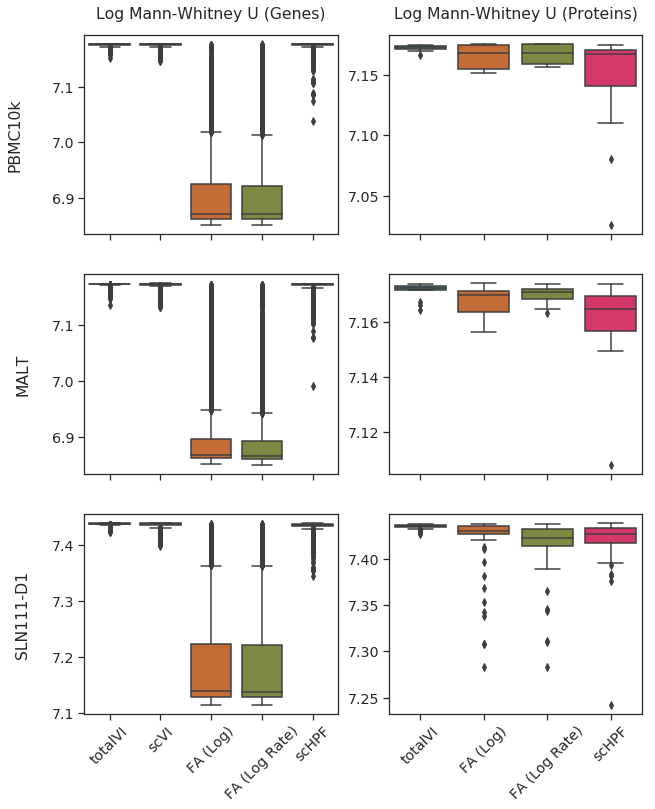

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(10, 12.5), sharex=False)
inds = [0, 2, 4]
for i, p, dataset in zip(inds, ppc_fulls, datasets):
    sns.set_palette(colors)
    sns.boxplot(
        data=np.log10(p.metrics["mannwhitneyu"].iloc[: dataset.nb_genes]),
        ax=ax.flat[i],
        order=["totalVI", "scVI", "FA (Log)", "FA (Log Rate)", "scHPF"]
    )

    sns.set_palette(colors_3)
    sns.boxplot(
        data=np.log10(p.metrics["mannwhitneyu"].iloc[dataset.nb_genes :]),
        ax=ax.flat[i + 1],
        order=["totalVI", "FA (Log)", "FA (Log Rate)", "scHPF"]
    )


title = ax.flat[0].set_title("Log Mann-Whitney U (Genes)")
title.set_position([0.5, 1.05])
title = ax.flat[1].set_title("Log Mann-Whitney U (Proteins)")
title.set_position([0.5, 1.05])
ax.flat[0].set_xticklabels([])
ax.flat[1].set_xticklabels([])
ax.flat[2].set_xticklabels([])
ax.flat[3].set_xticklabels([])
ax.flat[4].tick_params(axis="x", rotation=45)
ax.flat[5].tick_params(axis="x", rotation=45)
ax.flat[0].set_ylabel("PBMC10k", labelpad=30)
ax.flat[2].set_ylabel("MALT", labelpad=22)
ax.flat[4].set_ylabel("SLN111-D1", labelpad=22)
# sns.despine()

# plt.tight_layout()
plt.savefig("figures/box_MWU.pdf", bbox_inches="tight")

### Reconstruction Loss

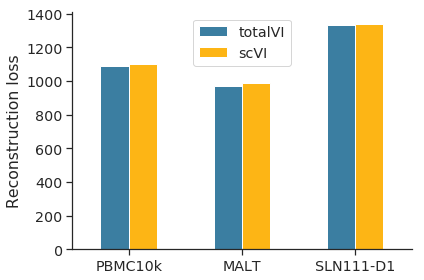

In [29]:
trainers = [trainer_pbmc, trainer_malt, trainer_sln]
scvi_trainers = [scvi_trainer_pbmc, scvi_trainer_malt, scvi_trainer_sln]

dnames = ["PBMC10k", "MALT", "SLN111-D1"]
reconst_df = pd.DataFrame(index=dnames, columns=["totalVI", "scVI"])

for dn, t, st in zip(dnames, trainers, scvi_trainers):
    reconst_df.loc[dn, "totalVI"] = t.validation_set.reconstruction_error(mode="gene")
    reconst_df.loc[dn, "scVI"] = st.validation_set.reconstruction_error()

fig, ax = plt.subplots(1, 1)
reconst_df.plot(kind="bar", color=colors, ax=ax)
sns.despine()
ax.set_ylabel("Reconstruction loss")
ax.tick_params(axis="x", rotation=0)
plt.tight_layout()
plt.savefig("figures/rec_error.pdf")

In [30]:
a=1